# CE Schedule Diagnostics

Analyze the supervised ResNet-18 cross-entropy training run stored under `outputs/CE_CIFAR10/`. Paths are relative to the repo root so the notebook can be executed in-place.


In [ ]:
from pathlib import Path
import math

import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8-darkgrid")

DATA_PATH = Path("outputs/CE_CIFAR10/CE_CIFAR10.csv")

df = pd.read_csv(DATA_PATH)
train_df = df[df["phase"] == "train"].copy()
train_df["epoch"] = train_df["epoch"].astype(int)

best_idx = train_df["val_accuracy"].idxmax()
best_epoch = int(train_df.loc[best_idx, "epoch"])
best_val = float(train_df.loc[best_idx, "val_accuracy"]) * 100
best_train = float(train_df.loc[best_idx, "train_accuracy"]) * 100


def set_epoch_ticks(ax, step=20):
    xmin, xmax = ax.get_xlim()
    start = max(0, step * math.floor(xmin / step))
    end = step * math.ceil(xmax / step)
    ticks = list(range(int(start), int(end) + step, step))
    ax.set_xticks(ticks)


def annotate_best(ax):
    ax.scatter(best_epoch, best_val, color="black", s=35, zorder=3, label=f"Best val acc {best_val:.2f}%")
    ax.annotate(
        f"epoch {best_epoch}\ntrain {best_train:.1f}%",
        (best_epoch, best_val),
        xytext=(12, -15),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", color="black", linewidth=1),
    )


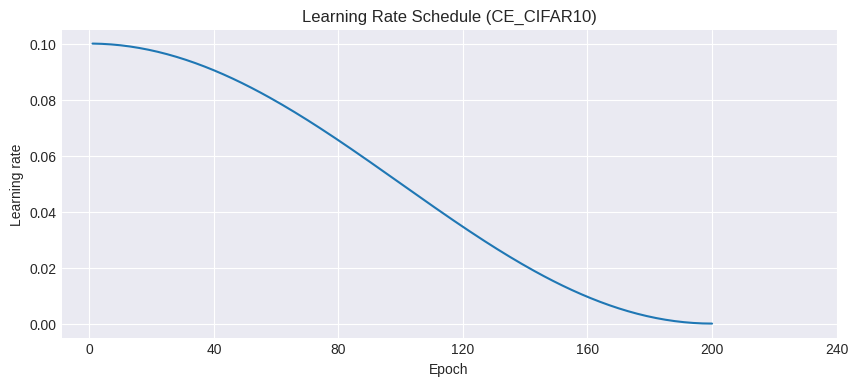

In [3]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(train_df["epoch"], train_df["learning_rate"], color="tab:blue")
ax.set_title("Learning Rate Schedule (CE_CIFAR10)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Learning rate")
set_epoch_ticks(ax, step=40)
plt.show()


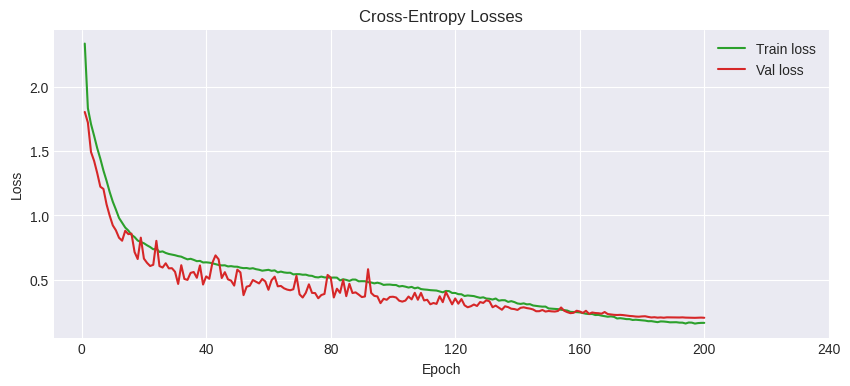

In [4]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(train_df["epoch"], train_df["train_loss"], label="Train loss", color="tab:green")
ax.plot(train_df["epoch"], train_df["val_loss"], label="Val loss", color="tab:red")
ax.set_title("Cross-Entropy Losses")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend(loc="upper right")
set_epoch_ticks(ax, step=40)
plt.show()


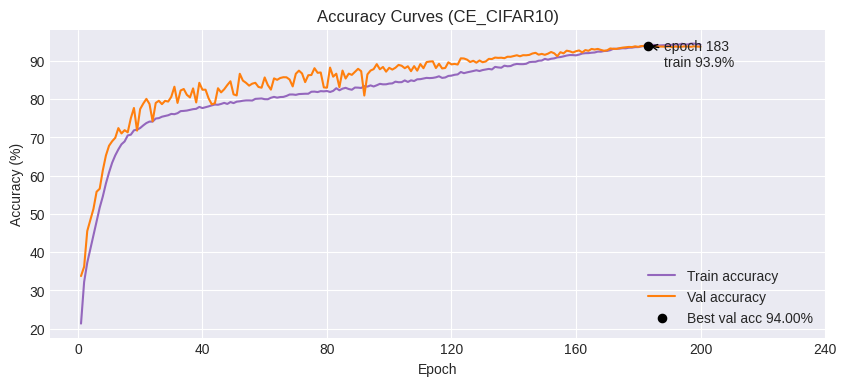

In [5]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(train_df["epoch"], train_df["train_accuracy"] * 100, label="Train accuracy", color="tab:purple")
ax.plot(train_df["epoch"], train_df["val_accuracy"] * 100, label="Val accuracy", color="tab:orange")
annotate_best(ax)
ax.set_title("Accuracy Curves (CE_CIFAR10)")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy (%)")
ax.legend(loc="lower right")
set_epoch_ticks(ax, step=40)
plt.show()


Collected 5000 feature vectors of dim 512


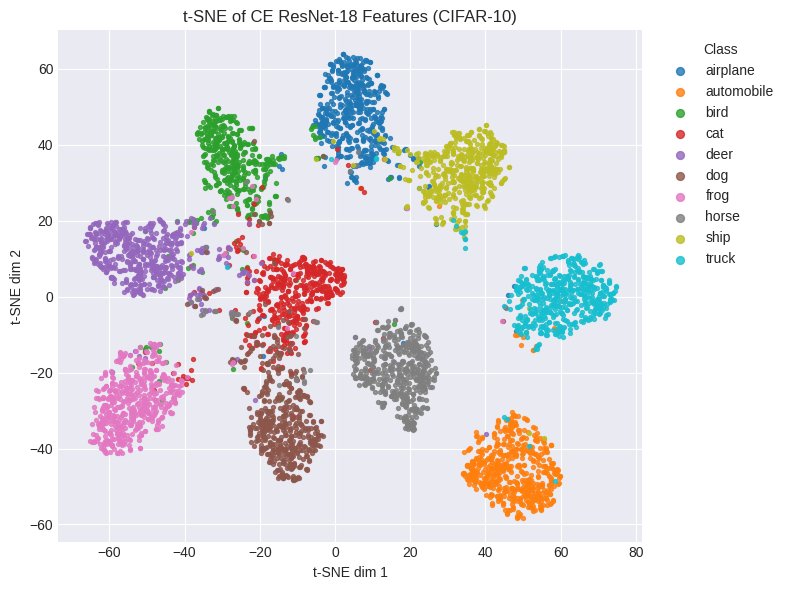

CPU times: user 26min 9s, sys: 3.16 s, total: 26min 13s
Wall time: 1min 5s


In [7]:
%%time

from pathlib import Path

import yaml
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, models, transforms
from sklearn.manifold import TSNE

CFG_PATH = Path("/home/sfooladi/github/SustainVision/outputs/CE_CIFAR10/CE_CIFAR10_model.yaml")
CKPT_PATH = Path("/home/sfooladi/github/SustainVision/outputs/CE_CIFAR10/CE_CIFAR10_model.pt")
DATA_ROOT = Path("/home/sfooladi/github/SustainVision/databases/cifar10")
SUBSET_SIZE = 5000
RANDOM_SEED = 42

PREFERRED_DEVICE = "cuda:1"
if torch.cuda.is_available():
    device = torch.device(PREFERRED_DEVICE if torch.cuda.device_count() > 1 else "cuda")
else:
    device = torch.device("cpu")

BATCH_SIZE = 512 if device.type == "cuda" else 128
NUM_WORKERS = 4 if device.type == "cuda" else 0

with CFG_PATH.open() as f:
    cfg = yaml.safe_load(f)

image_size = int(cfg["hyperparameters"].get("image_size", 32))
proj_dim = int(cfg["hyperparameters"].get("projection_dim", 128))
proj_hidden = int(cfg["hyperparameters"].get("projection_hidden_dim", max(512, proj_dim)))
num_classes = int(cfg["hyperparameters"].get("num_classes", 10))


def build_ce_model(num_classes: int, hidden_dim: int, out_dim: int) -> nn.Module:
    backbone = models.resnet18(weights=None)
    if image_size <= 64:
        backbone.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        backbone.maxpool = nn.Identity()
    feature_dim = backbone.fc.in_features
    backbone.fc = nn.Identity()

    classifier = nn.Linear(feature_dim, num_classes)
    projector = nn.Sequential(
        nn.Linear(feature_dim, hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, out_dim),
    )

    class CENet(nn.Module):
        def __init__(self, backbone, classifier, projector):
            super().__init__()
            self.backbone = backbone
            self.classifier = classifier
            self.projector = projector

        def forward(self, x, return_features: bool = False):
            feats = self.backbone(x)
            if isinstance(feats, tuple):
                feats = feats[0]
            if feats.ndim > 2:
                feats = torch.flatten(feats, 1)
            if return_features:
                return feats
            return self.classifier(feats)

    return CENet(backbone, classifier, projector)


def load_checkpoint(model: nn.Module, ckpt_path: Path, map_device: torch.device) -> nn.Module:
    payload = torch.load(ckpt_path, map_location=map_device)
    state = None
    if isinstance(payload, dict):
        state = payload.get("model_state") or payload.get("state_dict")
    if state is None:
        state = payload

    cleaned = {}
    for k, v in state.items():
        key = k
        if key.startswith("model."):
            key = key[len("model.") :]
        if key.startswith("module."):
            key = key[len("module.") :]
        cleaned[key] = v

    missing, unexpected = model.load_state_dict(cleaned, strict=False)
    if missing:
        print("Missing keys:", missing)
    if unexpected:
        print("Unexpected keys:", unexpected)
    return model


def ce_eval_transform() -> transforms.Compose:
    normalize = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
    return transforms.Compose(
        [
            transforms.Resize(image_size),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            normalize,
        ]
    )


model = build_ce_model(num_classes, proj_hidden, proj_dim)
model = load_checkpoint(model, CKPT_PATH, device)
model.to(device)
model.eval()
for param in model.parameters():
    param.requires_grad_(False)

val_dataset = datasets.CIFAR10(
    root=DATA_ROOT,
    train=False,
    download=True,
    transform=ce_eval_transform(),
)

generator = torch.Generator().manual_seed(RANDOM_SEED)
subset_indices = torch.randperm(len(val_dataset), generator=generator)[: min(SUBSET_SIZE, len(val_dataset))]
subset = Subset(val_dataset, subset_indices.tolist())

loader = DataLoader(
    subset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=(device.type == "cuda"),
)

all_feats, all_labels = [], []
with torch.inference_mode():
    for images, targets in loader:
        images = images.to(device, non_blocking=True)
        feats = model(images, return_features=True)
        all_feats.append(feats.cpu())
        all_labels.append(targets)

features = torch.cat(all_feats).numpy()
labels = torch.cat(all_labels).numpy()
print(f"Collected {features.shape[0]} feature vectors of dim {features.shape[1]}")

embeddings = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate=200,
    init="pca",
    random_state=RANDOM_SEED,
).fit_transform(features)

plt.figure(figsize=(8, 6))
colors = plt.cm.tab10(np.linspace(0, 1, len(val_dataset.classes)))
for idx, cls_name in enumerate(val_dataset.classes):
    mask = labels == idx
    plt.scatter(
        embeddings[mask, 0],
        embeddings[mask, 1],
        s=8,
        alpha=0.8,
        color=colors[idx],
        label=cls_name,
    )

plt.title("t-SNE of CE ResNet-18 Features (CIFAR-10)")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.legend(markerscale=2, bbox_to_anchor=(1.02, 1), loc="upper left", title="Class")
plt.tight_layout()
plt.show()

